In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import *
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE


In [96]:
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 70)


In [97]:
latam_df = pd.read_csv("dataset_SCL.csv", dtype= {'Vlo-I': str, 'Vlo-O': str})


<h1>1. Initial data exploration</h1>

In [98]:
print("Shape of Dataframe:", format(latam_df.shape))
latam_df.head()

Shape of Dataframe: (68206, 18)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,ANO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1.0,1.0,2017.0,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2.0,1.0,2017.0,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3.0,1.0,2017.0,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4.0,1.0,2017.0,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5.0,1.0,2017.0,Jueves,I,American Airlines,Santiago,Miami


Preprocess of the data

General overview of the data

In [99]:
for col in latam_df:
    print("Column:", col, "- Unique values:", len(latam_df[col].unique()))


Column: Fecha-I - Unique values: 53271
Column: Vlo-I - Unique values: 582
Column: Ori-I - Unique values: 2
Column: Des-I - Unique values: 62
Column: Emp-I - Unique values: 31
Column: Fecha-O - Unique values: 62743
Column: Vlo-O - Unique values: 858
Column: Ori-O - Unique values: 2
Column: Des-O - Unique values: 61
Column: Emp-O - Unique values: 33
Column: DIA - Unique values: 32
Column: MES - Unique values: 13
Column: ANO - Unique values: 3
Column: DIANOM - Unique values: 8
Column: TIPOVUELO - Unique values: 3
Column: OPERA - Unique values: 24
Column: SIGLAORI - Unique values: 2
Column: SIGLADES - Unique values: 60


<p>Since Ori-I, ORI-O and SIGLAORI columns just have one unique value, they provide no information, so they will be dropped.</p>
<p>Exploring AÑO and TIPOVUELO, we can see that in he case of ANO, the few rows that are not 2017 are flights programmed for 2017, so we drop this column aswell. 
We can drop the 39 columns of NaN in TIPOVUELO since they're filled with NaN fields.</p>
<p> We can also see that there's a clear correlation in SIGLADES and Des-O, since they're basically the same data, so we can drop one of these. In this case, we'll drop SIGLADES. </p>

In [100]:
latam_df.drop(labels=['Ori-I','SIGLAORI','ANO','Ori-O','SIGLADES'], axis=1,inplace=True)
latam_df.dropna(axis=0, subset=['TIPOVUELO'])

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1.0,1.0,Domingo,I,American Airlines
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2.0,1.0,Lunes,I,American Airlines
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3.0,1.0,Martes,I,American Airlines
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4.0,1.0,Miercoles,I,American Airlines
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5.0,1.0,Jueves,I,American Airlines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22.0,12.0,Viernes,I,JetSmart SPA
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25.0,12.0,Lunes,I,JetSmart SPA
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27.0,12.0,Miercoles,I,JetSmart SPA
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29.0,12.0,Viernes,I,JetSmart SPA


Now that we dropped the columns that we don't need, we can see the distribution of some of these columns. We're going to pay attention to the most interesting features

<Axes: xlabel='OPERA', ylabel='count'>

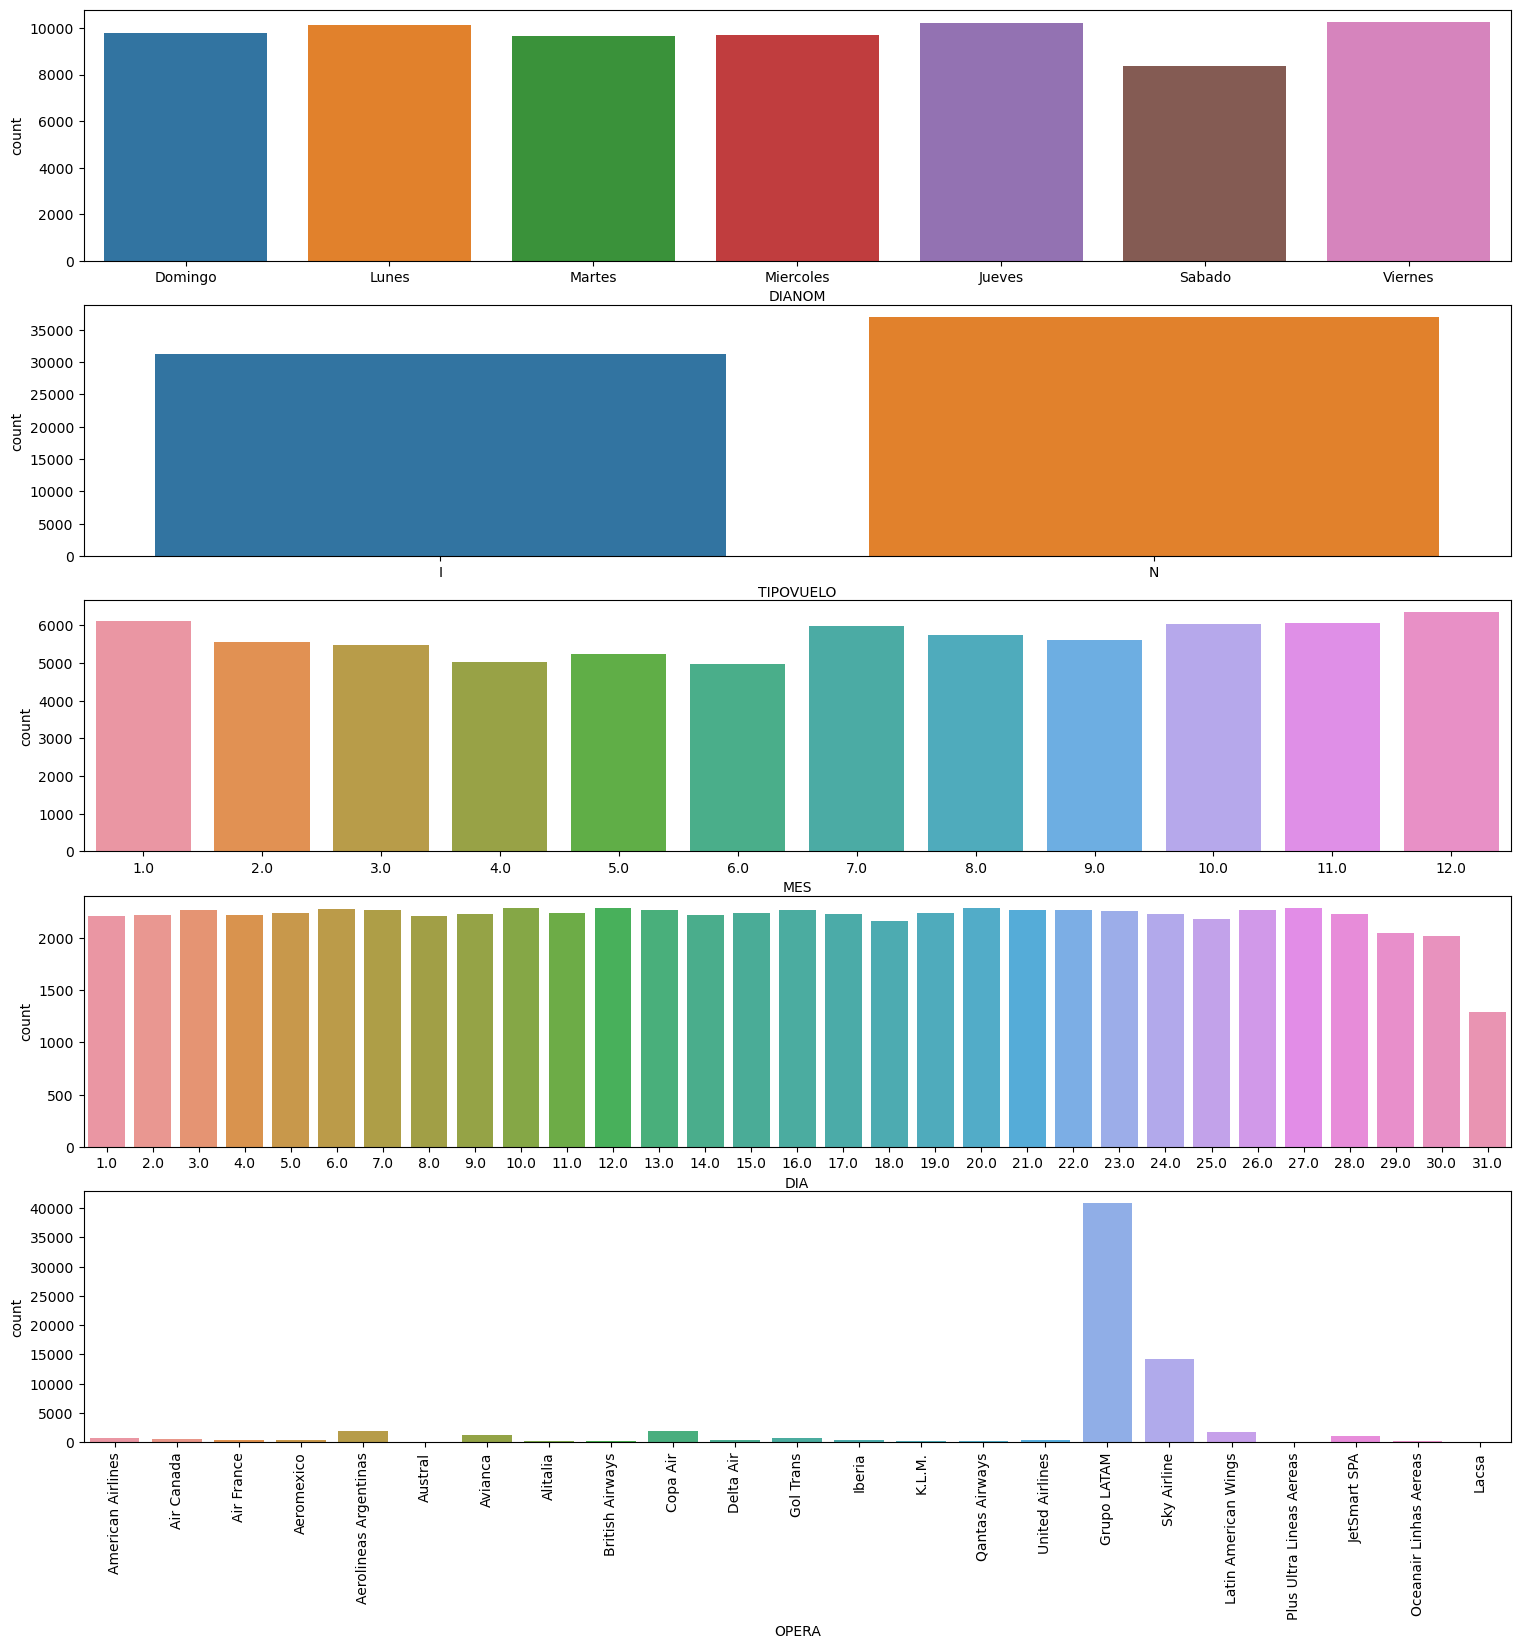

In [101]:
fig, ax =plt.subplots(5,1,figsize=(15, 15))
plt.xticks(rotation=90)
fig.tight_layout()
ax[4].tick_params(axis='x', rotation=90)
sns.countplot(x=latam_df["DIANOM"], ax=ax[0])
sns.countplot(x=latam_df["TIPOVUELO"], ax = ax[1])
sns.countplot(x=latam_df["MES"], ax = ax[2])
sns.countplot(x=latam_df["DIA"], ax = ax[3])
sns.countplot(x=latam_df["OPERA"], ax = ax[4])


We can see that the dataset is quite balanced regarding the data distribution, except for the Airline that operates, which is heavily skewed towards LATAM, Skyand Sky Airline. Which makes a lot of sense considering the Origin Airport is SCEL. This means that the data is very representative of the situation in SCEL airport, so the conclusions drawn from this dataset could apply to real life and it is probably a data set that contains every flight with origin in SCL in 2017. 


We can also see that the distribution of destinations varies a lot, with some destinations having over 5000 flights and some having even less than 100

<Axes: xlabel='Des-I', ylabel='count'>

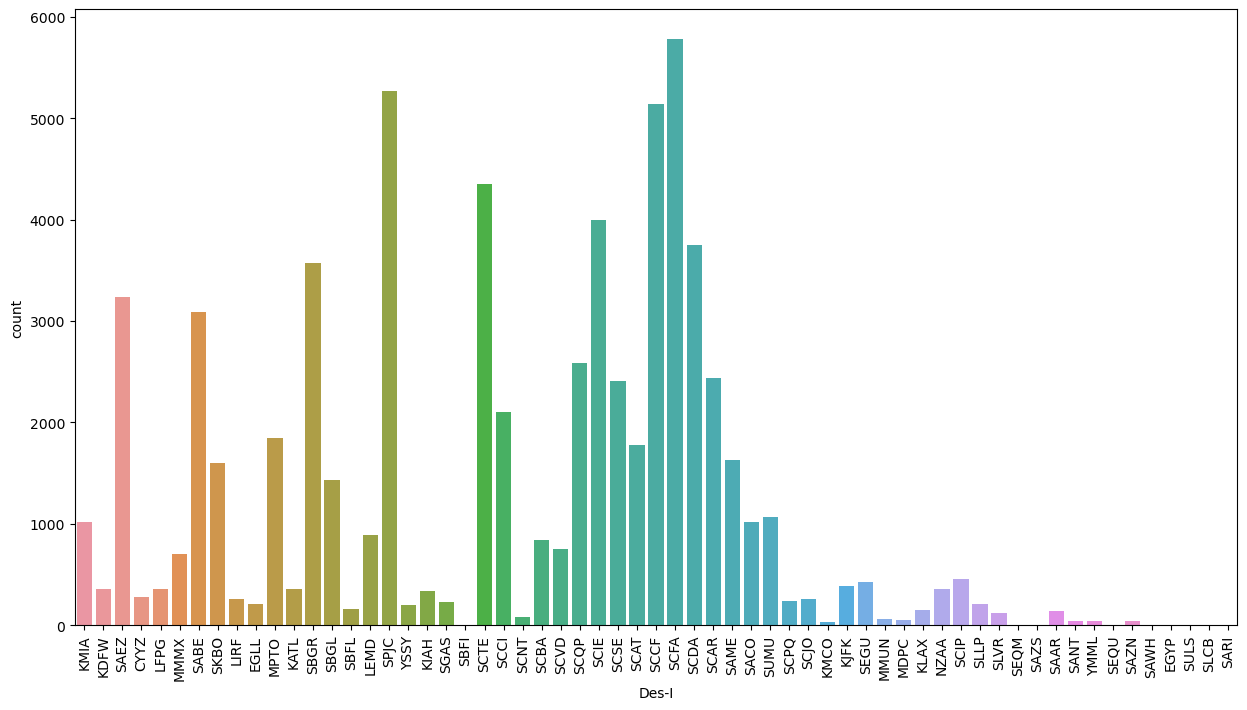

In [102]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.countplot(x=latam_df["Des-I"])

Finally, we see the columns that contain null values. Since they're so few compared to the dataset, fixing them would not give a lot of value, so we drop them.

PS: In a real world scenario, depending on the size of the dataset, I would probably process these rows in order to make them work and split the data by commas, but because of time limitations I'll drop them.


In [103]:
latam_df[latam_df.isnull().any(axis=1)]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA
6068,2017-01-19 11:00:00,200,SPJC,LAW,2017-01-19 11:03:00,NaN,SPJC,56R,19.0,1.0,Jueves,I,Latin American Wings
17059,"2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17060,"2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39316,"2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55332,"2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55333,"2017-10-05 08:00:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55334,"2017-10-06 08:10:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55335,"2017-10-12 08:00:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55336,"2017-10-13 08:10:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55337,"2017-10-17 08:00:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
latam_df.dropna(how='any', inplace=True)

<h1>2. Synthetic Column Generation</h1> 
<p> 1st step: Definition of functions </p>

In [105]:
#Parses Fecha-I as a datetime with given format and compares if its before march 3th or after dec 15
def is_high_season(row):
    date = datetime.strptime(row['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    if (date < datetime(2017, 3, 3) or date > datetime(2017,12,15)):
        return 1
    else:
        return 0
#Parses Fecha-I and Fecha-O as datetimes, calculates delta time and converts it to minutes
def get_time_diff(row):
    initial_date = datetime.strptime(row['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    actual_date = datetime.strptime(row['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    delta_time = actual_date - initial_date #returns delta time 
    return delta_time.total_seconds()/60 #converts to seconds and divide by 60 to get minutes

#self explanatory
def is_high_delay(row):
    return 1 if row['min_diff'] > 15 else 0 
 
#For simplicity, convert hour to elapsed seconds since day started and compare with the mentioned hours converted to seconds aswell
def get_period_day(row):
    initial_date = datetime.strptime(row['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    initial_time = initial_date.time()
    initial_time_seconds = initial_time.hour*60*60 + initial_time.minute*60
    if initial_time_seconds >= 5*60*60 and initial_time_seconds < 12*60*60:
        return 'morning'
    elif initial_time_seconds >= 12*60*60 and initial_time_seconds < 19*60*60:
        return 'afternoon'
    else:
        return 'night'

Applying the new functions to the dataframe

In [106]:
latam_df['high_season'] = latam_df.apply(is_high_season, axis=1)
latam_df['min_diff'] = latam_df.apply(get_time_diff, axis=1)
latam_df['delay_15'] = latam_df.apply(is_high_delay, axis=1)
latam_df['period_day'] = latam_df.apply(get_period_day, axis=1)

In [107]:
synthetic_features = ['high_season','min_diff','delay_15','period_day']
latam_df[synthetic_features].to_csv('synthetic_features.csv', index=False)

<h1>3. Delay rate behaviour 

In the case of features with high cardinality, we'll group the ones that are less frequent into a "other" group for a better visualization in the plots.

We'll set an arbitrary threshold to group them for each feature.

We'll set a threshold of 1%, so every value that is less than 1% in frequency will be classified as "other". Note that this will be just for data visualization (for now).

In [108]:
high_cardinality_columns = ['Des-I', 'Emp-I', 'Des-O', 'Emp-O','OPERA']

for col in high_cardinality_columns:
    print(col + "\n")
    value_frequencies = latam_df[col].value_counts(normalize=True).mul(100).round(1)
    condition = value_frequencies < 1
    filtered_values = value_frequencies[condition].index
    mask_dict = dict.fromkeys(filtered_values, 'other')
    print("Previous cardinality:",len(latam_df[col].unique()))
    print("New cardinality",len(latam_df[col].replace(mask_dict).unique())) 
    print("\n")
    new_col = col + "_reduced"
    latam_df[new_col] = latam_df[col].replace(mask_dict)

Des-I

Previous cardinality: 61
New cardinality 26


Emp-I

Previous cardinality: 30
New cardinality 11


Des-O

Previous cardinality: 60
New cardinality 26


Emp-O

Previous cardinality: 32
New cardinality 13


OPERA

Previous cardinality: 23
New cardinality 10




We'll use box plots for the visualization of the relation between delay time and different features. 

<Axes: xlabel='OPERA_reduced', ylabel='min_diff'>

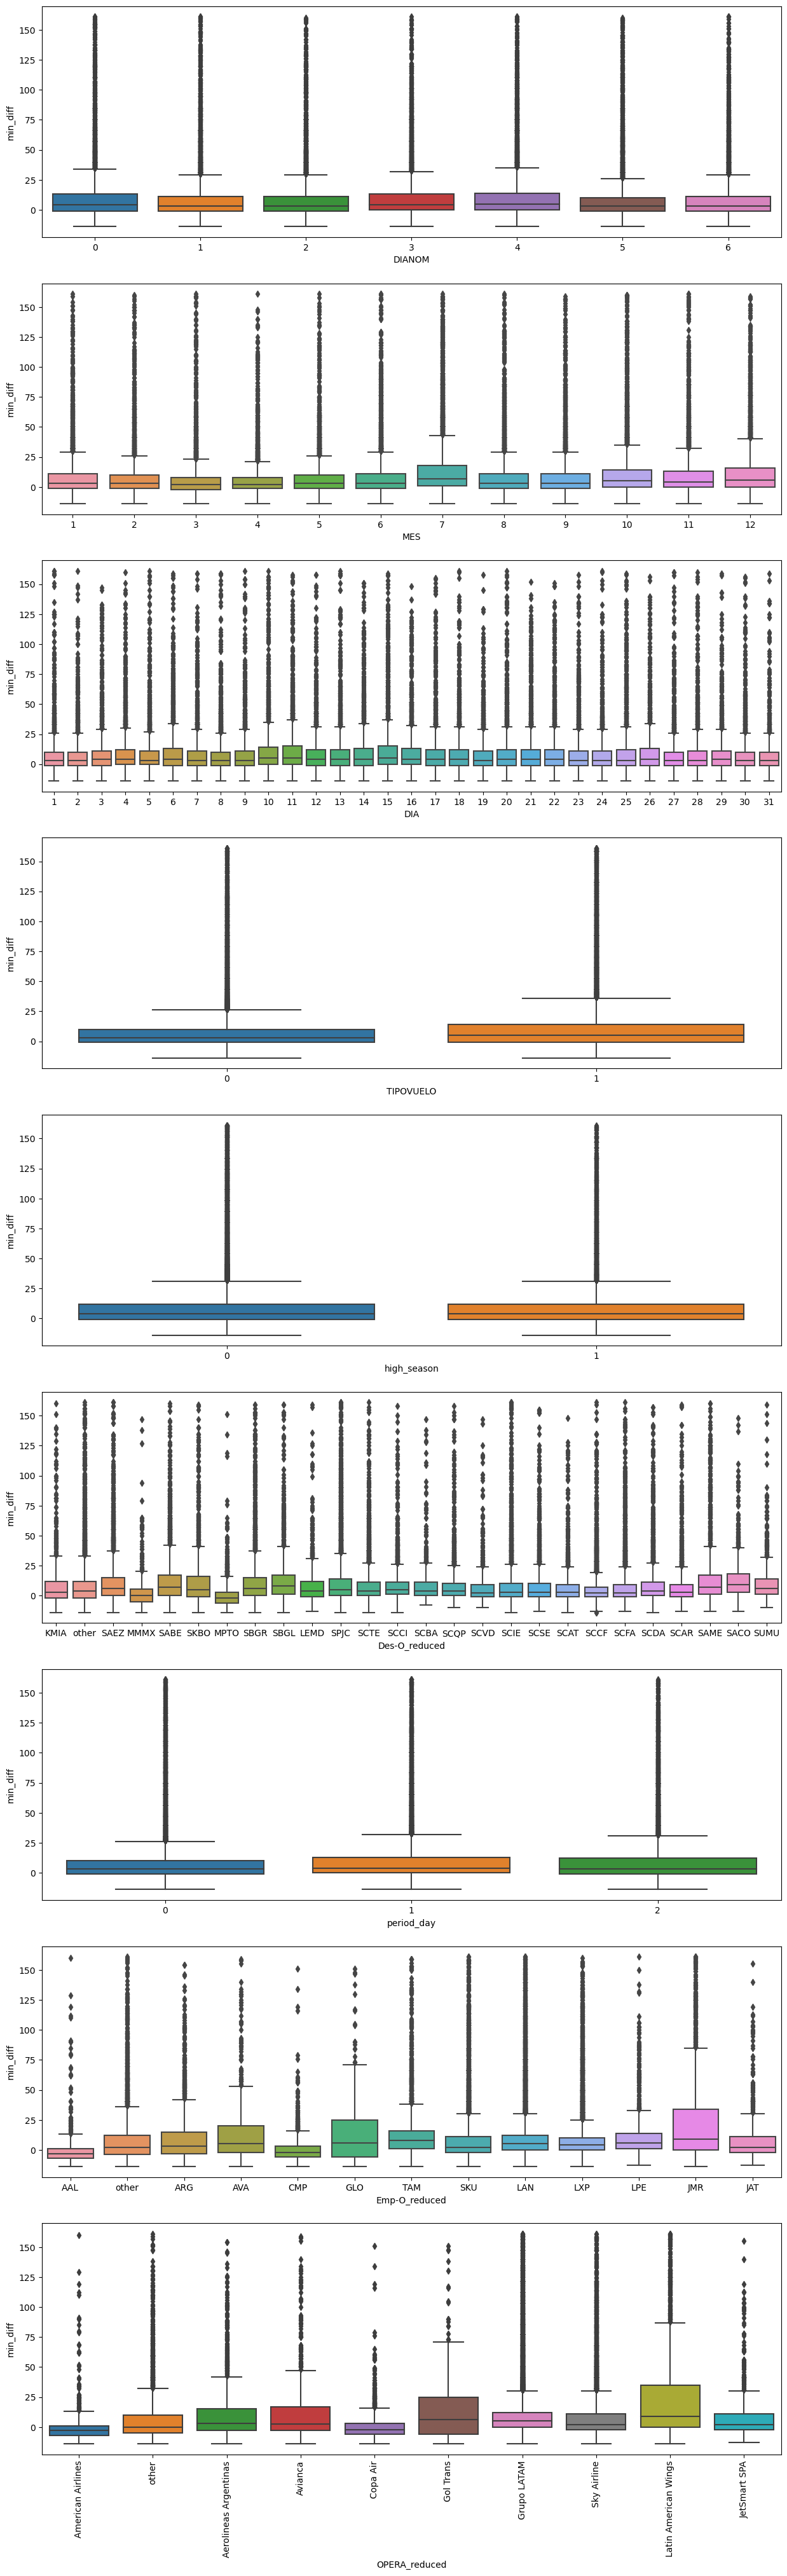

In [136]:
#This could be done smoother in a for loop but it started as just a couple box plots
fig, ax =plt.subplots(9,1,figsize=(15, 50))
plt.xticks(rotation=90)
sns.boxplot(data=latam_df, x='DIANOM',y=latam_df['min_diff'], ax = ax[0])
sns.boxplot(data=latam_df, x='MES',y=latam_df['min_diff'], ax = ax[1])
sns.boxplot(data=latam_df, x='DIA',y=latam_df['min_diff'], ax = ax[2])
sns.boxplot(data=latam_df, x='TIPOVUELO',y=latam_df['min_diff'], ax = ax[3])
sns.boxplot(data=latam_df, x='high_season',y=latam_df['min_diff'], ax = ax[4])
sns.boxplot(data=latam_df, x='Des-O_reduced',y=latam_df['min_diff'], ax = ax[5])
sns.boxplot(data=latam_df, x='period_day',y=latam_df['min_diff'], ax = ax[6])
sns.boxplot(data=latam_df, x='Emp-O_reduced',y=latam_df['min_diff'], ax = ax[7])
sns.boxplot(data=latam_df, x='OPERA_reduced',y=latam_df['min_diff'], ax = ax[8])

What we can see from these plots is:
<li> Day of the week (DIANOM): We can see that they're pretty similar, with days such as monday, thursday and friday a little higher than the rest.
<li> For the month (MES), we can see that July has a higher median than the rest, and December has also a higher median. This is probably explained because these months match with vacations and there's a higher volume of flights, causing delays.
<li> For day of the month, there's no clear tendency, we can see that their medians are not far from each other.
<li> For flight type, there's a difference for international flights, that have a higher median, and most importantly a higher Q3.
<li> For high season, surprisingly, the difference is not very pronounced.
<li> For Destination (O), we can see that there are interesting differences between different destinations, which means this could be an important factor when determining the delay probability.
<li> For period of the day, the afternoon is a little higher than the rest, but it's not that clear
<li> For Emp-O, there are big differences aswell, so this is probably another important feature to consider in the models.
<li> Lastly, the Airline Operator is also an important feature, since we can see that the box plots differ quite a lot, the airline with the most delays seems to be Latin American Wings.
    
<h4>These plots give us some information, but we can also notice that they contain a lot of <b>outliers</b>, which are very important data to consider, so we'll re plot this changing the whiskers to include the range of 2%-98%.</h4>
    
PS: I could have just done this in the previous step, but I think it's worth explaining my reasoning to change the whiskers parameter of the plots

<Axes: xlabel='OPERA_reduced', ylabel='min_diff'>

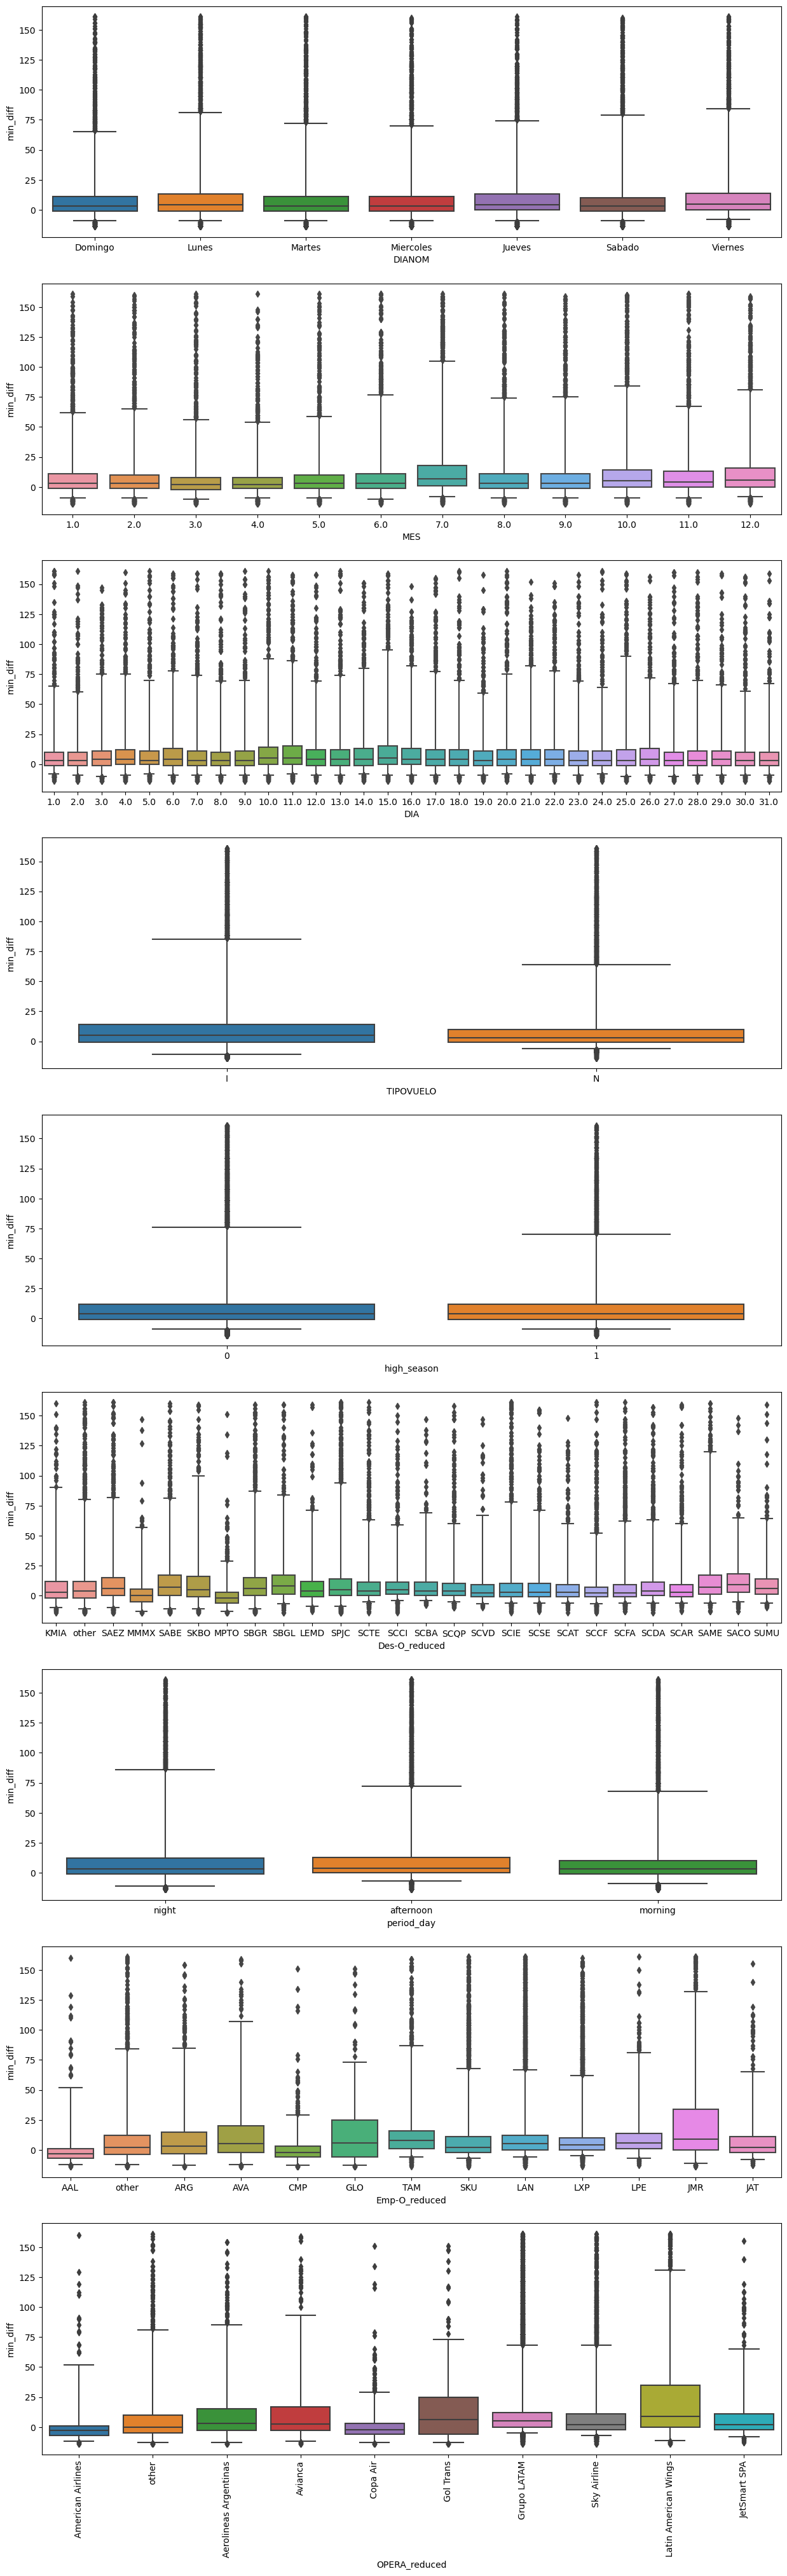

In [110]:
fig, ax =plt.subplots(9,1,figsize=(15, 50))
plt.xticks(rotation=90)
sns.boxplot(data=latam_df, x='DIANOM',y=latam_df['min_diff'], ax = ax[0],whis=[2, 98])
sns.boxplot(data=latam_df, x='MES',y=latam_df['min_diff'], ax = ax[1],whis=[2, 98])
sns.boxplot(data=latam_df, x='DIA',y=latam_df['min_diff'], ax = ax[2],whis=[2, 98])
sns.boxplot(data=latam_df, x='TIPOVUELO',y=latam_df['min_diff'], ax = ax[3],whis=[2, 98])
sns.boxplot(data=latam_df, x='high_season',y=latam_df['min_diff'], ax = ax[4],whis=[2, 98])
sns.boxplot(data=latam_df, x='Des-O_reduced',y=latam_df['min_diff'], ax = ax[5],whis=[2, 98])
sns.boxplot(data=latam_df, x='period_day',y=latam_df['min_diff'], ax = ax[6],whis=[2, 98])
sns.boxplot(data=latam_df, x='Emp-O_reduced',y=latam_df['min_diff'], ax = ax[7],whis=[2, 98])
sns.boxplot(data=latam_df, x='OPERA_reduced',y=latam_df['min_diff'], ax = ax[8],whis=[2, 98])

Now that we're getting less outliers, the differences are more noticeable.

We can see for example, a more pronounced delay difference in July and December, and we can also see that, in general, from October up to February, the flights tend to have a higher delay than in the rest of the months.

International flights also have a clearer difference that what we were seeing before.

Regarding destinations, we still see that it varies a lot between different values.

We can see that nights also have a good amount of delays, and have their max value even surpassing the afternoon.

The other features still have the same conclusions, since we can see how they differ a lot and will help us determine the delay possibility.

In [137]:
latam_df

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,high_season,min_diff,delay_15,period_day,Des-I_reduced,Emp-I_reduced,Des-O_reduced,Emp-O_reduced,OPERA_reduced,was_dif_emp,was_dif_des,was_dif_vlo,amount_of_flights
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,6,1,American Airlines,1,3.0,0,2,KMIA,AAL,KMIA,AAL,American Airlines,0,0,0,72
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,0,1,American Airlines,1,9.0,0,2,KMIA,AAL,KMIA,AAL,American Airlines,0,0,0,73
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,1,1,American Airlines,1,9.0,0,2,KMIA,AAL,KMIA,AAL,American Airlines,0,0,0,72
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,2,1,American Airlines,1,3.0,0,2,KMIA,AAL,KMIA,AAL,American Airlines,0,0,0,68
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,3,1,American Airlines,1,-2.0,0,2,KMIA,AAL,KMIA,AAL,American Airlines,0,0,0,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22,12,4,1,JetSmart SPA,1,46.0,1,1,SPJC,JAT,SPJC,JAT,JetSmart SPA,0,0,1,134
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25,12,0,1,JetSmart SPA,1,16.0,1,1,SPJC,JAT,SPJC,JAT,JetSmart SPA,0,0,1,127
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27,12,2,1,JetSmart SPA,1,40.0,1,1,SPJC,JAT,SPJC,JAT,JetSmart SPA,0,0,1,128
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29,12,4,1,JetSmart SPA,1,13.0,0,1,SPJC,JAT,SPJC,JAT,JetSmart SPA,0,0,1,129


<h1>4. Model creation</h1>
    
We'll start by doing the feature engineering.

Transforming the data from object to datetime to make it simpler

In [111]:
latam_df['Fecha-I'] = pd.to_datetime(latam_df['Fecha-I'])
latam_df['Fecha-O'] = pd.to_datetime(latam_df['Fecha-O'])

We'll add new features that could help in predicting the outcome. First, we'll define the functions to calculate these features.

We'll use the data we have about original Emp, Des and Vlo. If it changed, it might influence possibility of delaying the flight. We will also calculate the amount of flights 6 hours before and after the flight time in order to see how busy was the airport at the time.

Note that an interesting variable that could be added is the season (ie spring, summer, etc). But, because it heavily correlates with the month variable, we will not be adding it.

In [112]:
def was_dif_emp(row):
    if row['Emp-I'] != row['Emp-O']:
        return 1
    else:
        return 0
def was_dif_des(row):
    if row['Des-I'] != row['Des-O']:
        return 1
    else:
        return 0
def was_dif_vlo(row):
    if row['Vlo-I'] != row['Vlo-O']:
        return 1
    else:
        return 0
def amount_of_flights(row, df):
    reference_date = row['Fecha-I']
    low_end = row['Fecha-I'] - timedelta(hours=6)
    high_end = row['Fecha-I'] + timedelta(hours=6)
    aux_df = df[(df['Fecha-I'] > low_end) & (df['Fecha-I'] < high_end)]
    return len(aux_df)
    
    
    

If we had the data available, from example using an API, we could also check the <b>weather</b> in the trajectory, the <b>number of delays</b> in that day, and the <b>amount of flights the plane has done in the recent time</b> (it could be related to chance of having technical problems), which could provide very important insights.

In [113]:
latam_df['was_dif_emp'] = latam_df.apply(was_dif_emp, axis=1)
latam_df['was_dif_des'] = latam_df.apply(was_dif_des, axis=1)
latam_df['was_dif_vlo'] = latam_df.apply(was_dif_vlo, axis=1)
latam_df['amount_of_flights'] = latam_df.apply(amount_of_flights, df=latam_df, axis=1)

In [114]:
latam_df.columns

Index(['Fecha-I', 'Vlo-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O', 'Des-O',
       'Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'high_season',
       'min_diff', 'delay_15', 'period_day', 'Des-I_reduced', 'Emp-I_reduced',
       'Des-O_reduced', 'Emp-O_reduced', 'OPERA_reduced', 'was_dif_emp',
       'was_dif_des', 'was_dif_vlo', 'amount_of_flights'],
      dtype='object')

Now that we have all the new features, we can deal with our categorical and numerical variables. First, we'll select the features that we're going to use for the prediction. We obviously cannot use features such as the initial date and final date, or the min_diff, since they're directly correlated to the prediction target. We also won't get value from using ID features like Vlo-I, instead, we'll consider if it changed or not. 

In [115]:
selected_features = ['Des-I', 'Emp-I', 'Des-O','Emp-O', 'DIA','MES','DIANOM','TIPOVUELO',
                     'OPERA','high_season','period_day','was_dif_emp','was_dif_des','was_dif_vlo',
                    'amount_of_flights']


Since every column is taken as object we will convert some of them to numerical, we will also encode ordinal 
categorical variables in this step, since it will not change the outcome if we do it now or after the test train split.

In [116]:
latam_df[selected_features] = latam_df[selected_features].astype({'DIA': 'int32','MES':'int32','high_season':'int32','was_dif_emp':'int32',
                                    'was_dif_vlo':'int32','was_dif_des':'int32','amount_of_flights':'int32'})

latam_df[selected_features]

,Des-I,Emp-I,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,high_season,period_day,was_dif_emp,was_dif_des,was_dif_vlo,amount_of_flights
0,KMIA,AAL,KMIA,AAL,1,1,Domingo,I,American Airlines,1,night,0,0,0,72
1,KMIA,AAL,KMIA,AAL,2,1,Lunes,I,American Airlines,1,night,0,0,0,73
2,KMIA,AAL,KMIA,AAL,3,1,Martes,I,American Airlines,1,night,0,0,0,72
3,KMIA,AAL,KMIA,AAL,4,1,Miercoles,I,American Airlines,1,night,0,0,0,68
4,KMIA,AAL,KMIA,AAL,5,1,Jueves,I,American Airlines,1,night,0,0,0,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,SPJC,JAT,SPJC,JAT,22,12,Viernes,I,JetSmart SPA,1,afternoon,0,0,1,134
68202,SPJC,JAT,SPJC,JAT,25,12,Lunes,I,JetSmart SPA,1,afternoon,0,0,1,127
68203,SPJC,JAT,SPJC,JAT,27,12,Miercoles,I,JetSmart SPA,1,afternoon,0,0,1,128
68204,SPJC,JAT,SPJC,JAT,29,12,Viernes,I,JetSmart SPA,1,afternoon,0,0,1,129


DIANOM, TIPOVUELO and period_day can be considered ordinal categorical variables, therefore we'll encode these with custom functions depending on their values.

In [117]:
def encode_dianom(row):
    day= row['DIANOM']
    if (day == 'Lunes'):
        return 0
    elif (day == 'Martes'):
        return 1
    elif (day == 'Miercoles'):
        return 2
    elif (day == 'Jueves'):
        return 3
    elif (day == 'Viernes'):
        return 4
    elif (day == 'Sabado'):
        return 5
    elif (day == 'Domingo'):
        return 6
    else:
        return -1
def encode_tipovuelo(row):
    tipovuelo = row['TIPOVUELO']
    if (tipovuelo == 'N'):
        return 0
    elif (tipovuelo == 'I'):
        return 1
    else:
        return -1
    
def encode_period_day(row):
    period_day = row['period_day']
    if (period_day == 'morning'):
        return 0
    elif (period_day == 'afternoon'):
        return 1
    elif (period_day == 'night'):
        return 2
    else:
        return -1
    

In [118]:
latam_df['DIANOM'] = latam_df.apply(encode_dianom, axis=1)
latam_df['TIPOVUELO'] = latam_df.apply(encode_tipovuelo, axis=1)
latam_df['period_day'] = latam_df.apply(encode_period_day, axis=1)

We'll also do some <b>feature selection</b>, using a <b>Chi squared test</b> in order to see which categorical features are the most important. To do  this, we have to label encode our categorical variables first, and then we select the categories that have a lower p value

(array([12.49233537, 23.16046661, 12.23989955, 53.66440139,  0.08907647]), array([4.08625051e-04, 1.49029818e-06, 4.67783473e-04, 2.37833891e-13,
       7.65354533e-01]))


Emp-O    2.378339e-13
Emp-I    1.490298e-06
Des-I    4.086251e-04
Des-O    4.677835e-04
OPERA    7.653545e-01
dtype: float64

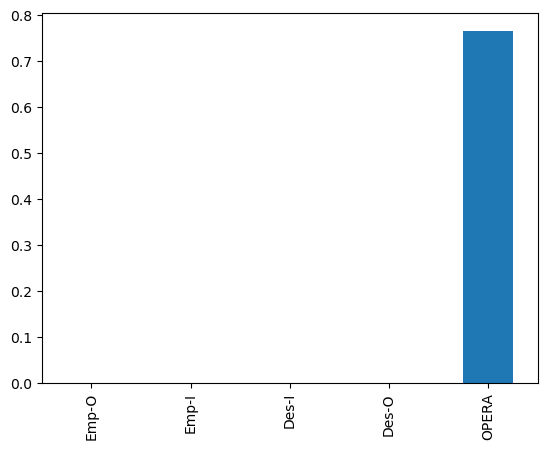

In [119]:
label_encoder = LabelEncoder()
cats = ['Des-I', 'Emp-I', 'Des-O','Emp-O','OPERA']
a = latam_df[cats]
b = pd.DataFrame()
for col in a:
    b[col] = label_encoder.fit_transform(a[col])
    
chi_scores = chi2(b,latam_df['delay_15'])
print(chi_scores)
p_values = pd.Series(chi_scores[1],index = b.columns)
p_values.sort_values(ascending = True , inplace = True)
p_values.plot.bar()
p_values


We can see that the OPERA variable has a very high Chi squared value, therefore, it will be discarded.

Assuming what we want to predict is wether the flight is going to be delayed or not (delay > 15 minutes). This is a binary classification problem. Since we will discard OPERA as a feature, we will update selected features columns

In [120]:
selected_features = ['Des-I', 'Emp-I', 'Des-O','Emp-O', 'DIA','MES','DIANOM','TIPOVUELO',
                     'high_season','period_day','was_dif_emp','was_dif_des','was_dif_vlo',
                    'amount_of_flights']


X = latam_df[selected_features]
y = latam_df['delay_15']

print(y.mean())

0.18493090396972098


Now we're almost ready to make our model! We just need to split the data into test and train, encode the missing categorical variables and scale the features. We'll choose a sample size of 20% of the dataset, and we'll use OneHotEncoder for the categorical variables, which is a good encoding method for moderate cardinality features.

But wait a moment! If we see our dataset, we can see that we have an imbalanced dataset, where we have positive cases of delay in less than 20% of our data, so we will keep an oversampled dataset using SMOTE. However, this has to be done after splitting, encoding and scaling the dataset.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#Reset index to avoid errors in scaling
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True,drop=True)


<h4>Encoding</h4> 

In [122]:
cols_to_encode = ['Des-I','Emp-I','Des-O','Emp-O']
OH_encoder= OneHotEncoder(handle_unknown = 'infrequent_if_exist',min_frequency=0.02,sparse_output=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[cols_to_encode]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[cols_to_encode]))

#add index to encoded rows
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index
#add column names
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()

#drop categorical columns
num_X_train = X_train.drop(cols_to_encode, axis=1)
num_X_test = X_test.drop(cols_to_encode, axis=1)

#concatenate new df to old
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

X_train = OH_X_train
X_test = OH_X_test





Creating metric and feature importance functions

In [123]:
def get_metrics(y_pred, y_test, est, X_test):
    print("Best F1 Macro Score: %.2f%%" % (metrics.f1_score(y_test,y_pred, average = 'macro') * 100.0))
    print(metrics.classification_report(y_test, y_pred, target_names=['Not delayed','Delayed']))
    metrics.ConfusionMatrixDisplay.from_estimator(
    est, X_test, y_test)
    

    
def get_feature_importances(est, columns):
    feat_importances = pd.Series(est.feature_importances_, index=columns)
    feat_importances.nlargest(30).plot(kind='barh',figsize=(15,15))
    plt.title("Top 30 important features")
    plt.show()



<h4>Scaling</h4> 
The only features we have to scale are DIA, MES, period_day and DIANOM and amount of flights, since the other variables are binary. In this step we can finally oversample our train data.

In [124]:
ss = StandardScaler()
cols_to_scale = ['DIA','MES','DIANOM','amount_of_flights','period_day']
X_train[cols_to_scale] = pd.DataFrame(ss.fit_transform(X_train[cols_to_scale]), columns=cols_to_scale)
X_test[cols_to_scale] = pd.DataFrame(ss.transform(X_test[cols_to_scale]), columns = cols_to_scale)

sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [125]:
X_train_res

,DIA,MES,DIANOM,TIPOVUELO,high_season,period_day,was_dif_emp,was_dif_des,was_dif_vlo,amount_of_flights,Des-I_MPTO,Des-I_SABE,Des-I_SAEZ,Des-I_SAME,Des-I_SBGL,Des-I_SBGR,Des-I_SCAR,Des-I_SCAT,Des-I_SCCF,Des-I_SCCI,Des-I_SCDA,Des-I_SCFA,Des-I_SCIE,Des-I_SCQP,Des-I_SCSE,Des-I_SCTE,Des-I_SKBO,Des-I_SPJC,Des-I_infrequent_sklearn,Emp-I_ARG,Emp-I_CMP,Emp-I_LAN,Emp-I_LAW,Emp-I_SKU,Emp-I_TAM,Emp-I_infrequent_sklearn,Des-O_MPTO,Des-O_SABE,Des-O_SAEZ,Des-O_SAME,Des-O_SBGL,Des-O_SBGR,Des-O_SCAR,Des-O_SCAT,Des-O_SCCF,Des-O_SCCI,Des-O_SCDA,Des-O_SCFA,Des-O_SCIE,Des-O_SCQP,Des-O_SCSE,Des-O_SCTE,Des-O_SKBO,Des-O_SPJC,Des-O_infrequent_sklearn,Emp-O_ARG,Emp-O_CMP,Emp-O_JMR,Emp-O_LAN,Emp-O_LXP,Emp-O_SKU,Emp-O_TAM,Emp-O_infrequent_sklearn
0,1.394534,-0.741266,0.523269,1,0,-1.126358,0,0,0,0.620763,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.991459,0.109870,0.523269,1,0,1.429029,1,0,0,-0.905164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.371965,0.393582,1.024549,1,0,0.151335,0,0,0,-0.905164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.258346,0.109870,-0.980573,0,0,-1.126358,0,0,0,0.875085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.167296,0.677294,-0.980573,0,0,0.151335,1,0,0,1.383727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88965,0.840465,-0.173842,0.523269,1,0,1.429029,0,0,0,-0.500941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
88966,-0.740117,-0.517746,-1.086924,1,0,1.429029,0,0,0,-0.851207,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
88967,-0.148083,1.528429,0.233963,0,0,-1.126358,0,0,0,1.573522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
88968,-0.395942,1.528429,0.021988,0,0,-1.126358,1,0,1,0.253189,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We'll create a function to make it easier to evaluate a model and get the best parameters by creating a function that does a gridsearch and evaluates the model

In [133]:
def get_tuned_model(model, parameters, X_train, y_train, X_test):
    tuned_model = RandomizedSearchCV(model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(shuffle=True,n_splits=2), 
                   scoring='f1_macro',
                   verbose=3, refit=True)
    tuned_model.fit(X_train, y_train)
    print(tuned_model.best_params_)
    y_pred = tuned_model.predict(X_test)
    get_metrics(y_pred,y_test,tuned_model, X_test)
    return tuned_model


<h3> Testing different models </h3>

Note: The parameter tuning was done through RandomizedSearchCV and it can be found at the bottom of the Notebook. Keep in mind some of these models took a long time to fine-tune.


<h1> Metric justification </h1>

The reason f1 macro score is used as the metric is because of the nature of the problem, where we have an unbalanced dataset and we want to have a good balance between precision and recall, and also give the same importance for both minority and majority classes. If we instead used a more common metric like "accuracy", we would've been misled by the results, since a "no skill" model could predict negative in every case and get a really good score of 80% for this exercise. 

[Source](http://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/=)


<h1>Model 1: XGBoost </h1>


First, XGBoost, a very competitive algorithm which gives very consistent results

Best F1 Macro Score: 60.27%
              precision    recall  f1-score   support

 Not delayed       0.85      0.89      0.87     11075
     Delayed       0.39      0.30      0.34      2559

    accuracy                           0.78     13634
   macro avg       0.62      0.60      0.60     13634
weighted avg       0.76      0.78      0.77     13634



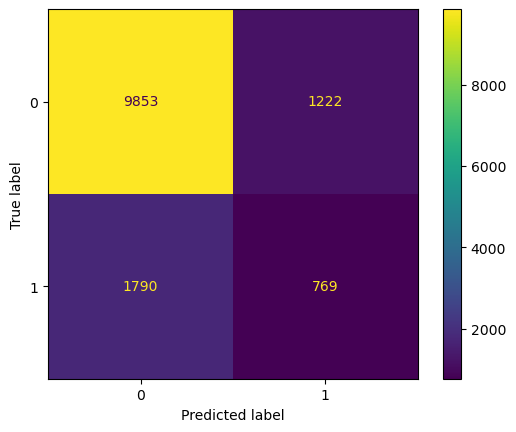

In [127]:
#Keeping this to avoid rerunning GridSearch
best_found_params = {'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 3000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'subsample': 1}

xgb_model = XGBClassifier(**best_found_params)
xgb_model.fit(X_train_res, y_train_res)
y_pred = xgb_model.predict(X_test)
get_metrics(y_pred,y_test,xgb_model, X_test)


<h2> Model 2: K Nearest Neighbors </h2>

Another very useful model that trains really fast and is really easy to interpret

Best F1 Macro Score: 56.31%
              precision    recall  f1-score   support

 Not delayed       0.84      0.77      0.80     11075
     Delayed       0.28      0.39      0.32      2559

    accuracy                           0.70     13634
   macro avg       0.56      0.58      0.56     13634
weighted avg       0.74      0.70      0.71     13634



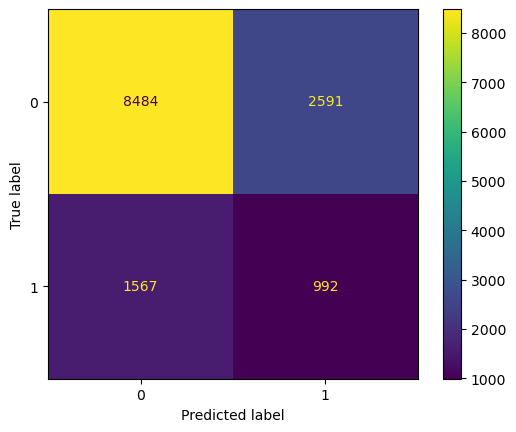

In [128]:
best_knn_params = {'weights': 'distance', 'n_neighbors': 1}
tuned_knn = KNeighborsClassifier(**best_knn_params)
tuned_knn.fit(X_train_res, y_train_res)
y_pred = tuned_knn.predict(X_test)
get_metrics(y_pred,y_test,tuned_knn, X_test)


<h2> Model 3: Random Forest  </h2>

Just another solid choice for binary classification problems that could serve as a baseline.

Best F1 Macro Score: 61.21%
              precision    recall  f1-score   support

 Not delayed       0.86      0.83      0.84     11075
     Delayed       0.36      0.41      0.38      2559

    accuracy                           0.75     13634
   macro avg       0.61      0.62      0.61     13634
weighted avg       0.76      0.75      0.76     13634



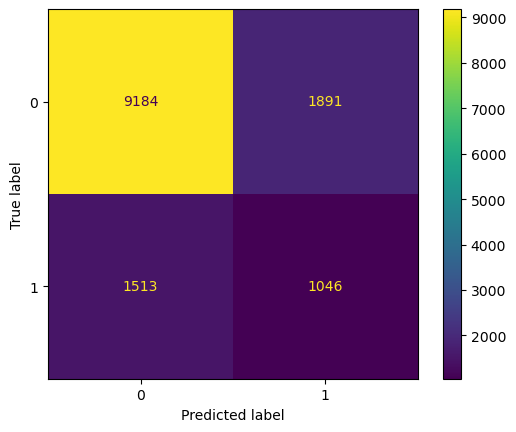

In [129]:
best_rf_params = {'n_estimators': 2500, 'max_features': 'log2', 'max_depth': 21, 'criterion': 'gini'}
tuned_rf = RandomForestClassifier(**best_rf_params)
tuned_rf.fit(X_train_res, y_train_res)
y_pred = tuned_rf.predict(X_test)
get_metrics(y_pred,y_test,tuned_rf, X_test)


<h2> Model 4: Multi Layer Perceptron </h2>

A simple neural network could also prove to be useful in this problem

Best F1 Macro Score: 57.43%
              precision    recall  f1-score   support

 Not delayed       0.85      0.76      0.80     11075
     Delayed       0.29      0.42      0.34      2559

    accuracy                           0.70     13634
   macro avg       0.57      0.59      0.57     13634
weighted avg       0.75      0.70      0.72     13634



C:\Users\fLoki\.conda\envs\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


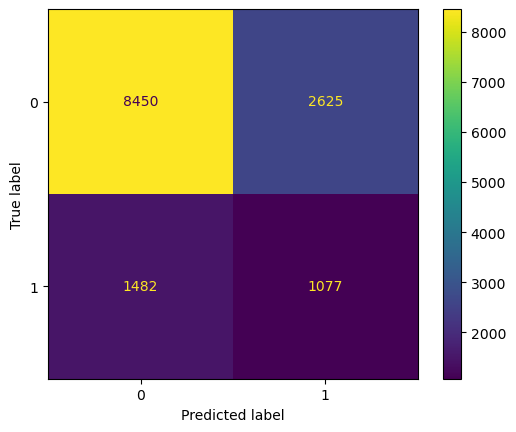

In [130]:
best_mlp_params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
tuned_mlp = MLPClassifier(**best_mlp_params)
tuned_mlp.fit(X_train_res, y_train_res)
y_pred = tuned_mlp.predict(X_test)
get_metrics(y_pred,y_test,tuned_mlp, X_test)

<h3>Summary</h3>

After trying and tunning our 4 different candidates, the best score we got was from the Random Forest. With a 61.27% f1 score (macro), a very good precision and recall for the negative class and a pretty low one for the positive class (minority class). 
What this score tells us is that is not very good at identifying possible delay cases. This could be improved without changing the model if we want to favour the detecting the delays at the cost of decreasing our metrics for the negative class, by lowering the prediction threshold. 

Since this is a random forest classifier, we can easily see which variables made the most impact by plotting the feature importances attribute of the estimator.

<h1> Calculating performance importance </h1>

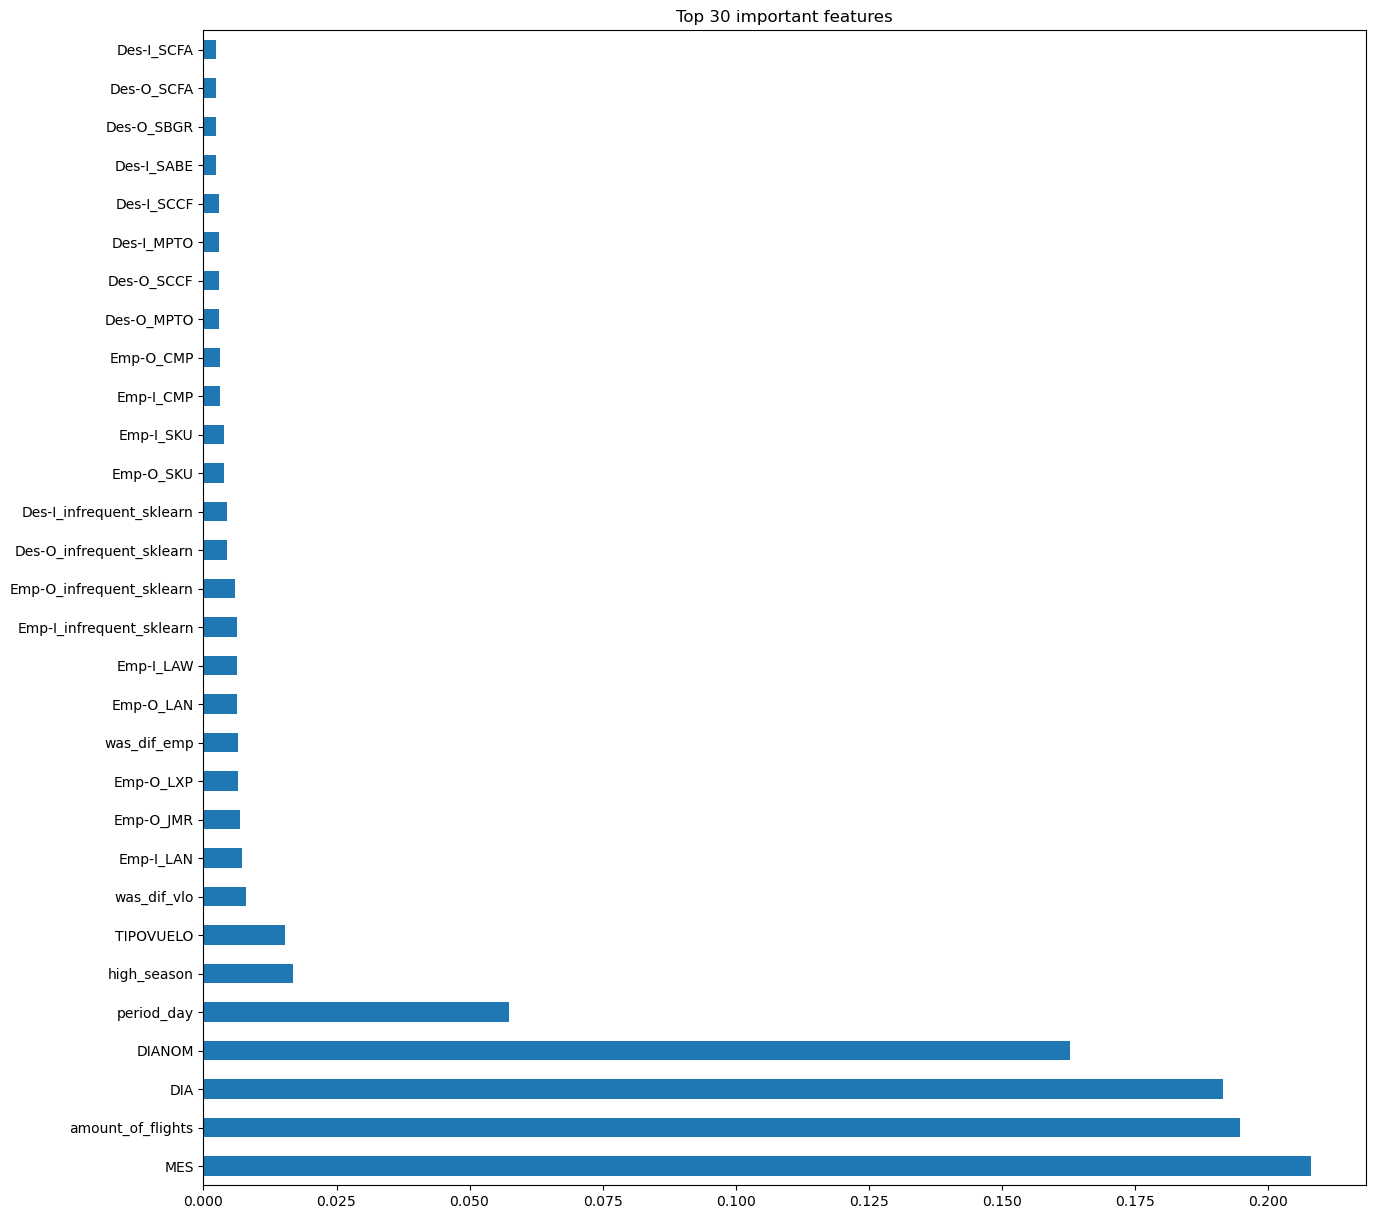

In [131]:
get_feature_importances(tuned_rf, X_train.columns)

We can see that the variables that had the most influence were related to the date (MES, DIA, DIANOM, period_day and high_season) and the amount of flights, which makes a lot of sense, since all of these variables are related to the volume of flights that arrive and depart in a certain given time. The other variables related to the Destination, Airlines and such did not play a big role in the outcome of the predictions, so in future studies removing them could probably be one of the first approaches.

<h1> Final conclusions </h1>

This model could've been improved by several means.

In the first place, I think the features we have are not good enough to predict with confidence wether a flight is going to be delayed or not, but we could get data that would help a lot in determining this. Getting the weather report of the trajectory of the flights would've probably been a very reasonable variable to have a better performing model. Other valuable information that could've been gathered could be statistics about the plane, like the model, how prone it is to technical difficulties and other characteristics. 

Still in the feature engineering phase, we could've ran a better analysis to do a better feature selection, since it's very likely that there are features that are not adding much value to the model and could even be harmful to it's performance, as mentioned earlier..

Also, since 4 models were tried, the general preprocessing of the data wasn't customized. Models tend to have advantages with certain preprocessing configurations, some models perform better when the number of features is low, some models could benefit from different characteristics of the data and this preprocessing wasn't done with Random Forest optimization in mind.

Last but not least, even though different encoding techniques were tried in previous versions (binary encoding), every encoding technique has its pros and cons and, due to the empirical nature of Machine Learning, the only way of finding the best model for a problem is through hours of trial and error with some general guidelines on what works and what doesn't.

<h2>Bonus: Trying a reduced amount of features </h2> 

We can test our hypothesis with a quick attempt at getting better results by just taking the top 7 most important features. However, the results were not better than with all the features. It's important to note though, that we can get almost the same results that we had with over 60 features with just 7! This confirms most of the information from the other features isn't really that helpful.

Fitting 2 folds for each of 10 candidates, totalling 20 fits
{'n_estimators': 500, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'entropy'}
Best F1 Macro Score: 55.77%
              precision    recall  f1-score   support

 Not delayed       0.83      0.87      0.85     11075
     Delayed       0.30      0.24      0.27      2559

    accuracy                           0.75     13634
   macro avg       0.56      0.55      0.56     13634
weighted avg       0.73      0.75      0.74     13634



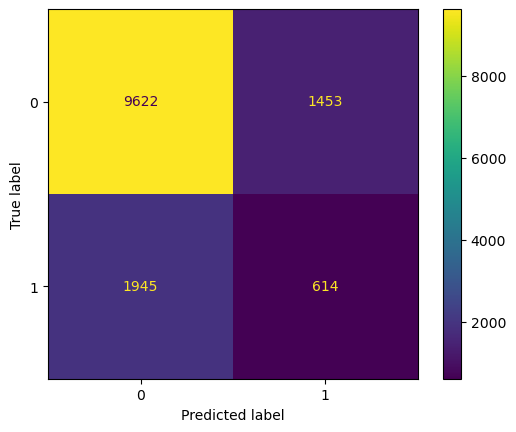

In [135]:

reduced_cols = ['DIA','MES','DIANOM','TIPOVUELO','high_season','period_day','amount_of_flights']
new_X_train = X_train_res[reduced_cols]
new_X_test = X_test[reduced_cols]

reduced_params = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [20,30,40,50],
    'criterion' :['gini', 'entropy']}

reduced_rf_model = RandomForestClassifier()


reduced_rf_model = get_tuned_model(reduced_rf_model,reduced_params,new_X_train, y_train_res, new_X_test)

<h1> Additional: RandomizedSearchCV for Parameter Tuning </h1>
    
I moved this section to the bottom so it becomes optional for the reviewer to do the parameter finding with RandomizedSearch, since it takes a long time to find the best perameters for each of the models, even with a reduced set of combinations.

<h2> XGBoost </h2>

In [ ]:
xgb_model = XGBClassifier()
xgb_parameters = {'nthread':[12], 
              'objective':['binary:logistic'],
              'learning_rate': [0.1,0.3,0.5,0.7], 
              'max_depth': [10,15,20],
              'min_child_weight': [1],
              'subsample': [1],
              'colsample_bytree': [0.7],
              'n_estimators': [3000], 
              'missing':[-999],
              'seed': [1337]}

tuned_xgb = get_tuned_model(xgb_model,xgb_parameters,X_train_res, y_train_res, X_test)


<h2> KNN </h2>

Fitting 2 folds for each of 10 candidates, totalling 20 fits
{'weights': 'uniform', 'n_neighbors': 3}
Best F1 Macro Score: 48.02%
              precision    recall  f1-score   support

 Not delayed       0.81      0.88      0.84     11075
     Delayed       0.15      0.10      0.12      2559

    accuracy                           0.73     13634
   macro avg       0.48      0.49      0.48     13634
weighted avg       0.69      0.73      0.71     13634



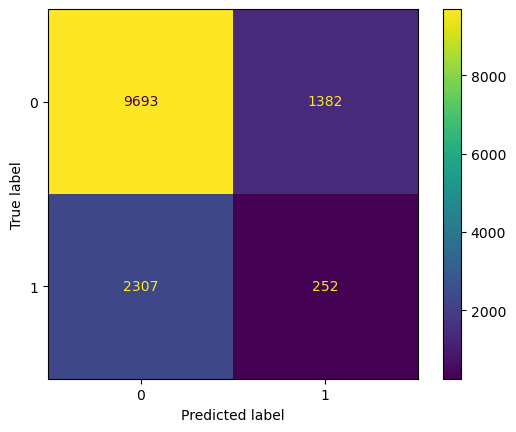

In [76]:
knn_model = KNeighborsClassifier()
knn_parameters = {'weights': ['uniform', 'distance'], 
               'n_neighbors': range(1,30)}

tuned_knn = get_tuned_model(knn_model,knn_parameters,X_train_res, y_train_res, X_test)
y_pred = tuned_knn.predict(X_test)

<h2> Random Forest </h2>

Fitting 2 folds for each of 10 candidates, totalling 20 fits


C:\Users\fLoki\.conda\envs\python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\fLoki\.conda\envs\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\fLoki\.conda\envs\python39\lib\site-packages\sklearn\ensemble\_forest.py", line 473, in fit
    trees = Parallel(
  File "C:\Users\fLoki\.conda\envs\python39\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_conf

{'n_estimators': 2500, 'max_features': 'log2', 'max_depth': 21, 'criterion': 'gini'}
Best F1 Macro Score: 61.16%
              precision    recall  f1-score   support

 Not delayed       0.86      0.83      0.84     11075
     Delayed       0.35      0.41      0.38      2559

    accuracy                           0.75     13634
   macro avg       0.61      0.62      0.61     13634
weighted avg       0.76      0.75      0.76     13634



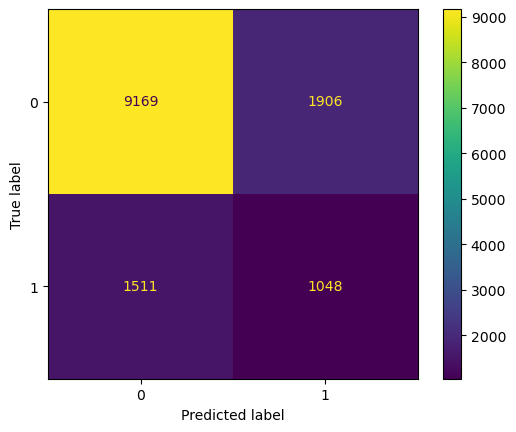

In [41]:
rf_model = RandomForestClassifier()
rf_parameters = { 
    'n_estimators': [2500,2000,1500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [15,17,21],
    'criterion' :['gini', 'entropy']
}

tuned_rf = get_tuned_model(rf_model,rf_parameters,X_train_res, y_train_res, X_test)

<h2> Multi Layer Perceptron </h2>

In [ ]:
mlp_model = MLPClassifier()
mlp_parameters = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],}

tuned_mlp = get_tuned_model(mlp_model,mlp_parameters,X_train_res, y_train_res, X_test)